In [54]:
import nbformat
from pathlib import Path
import re
from datetime import datetime
from matplotlib import pyplot as plt
import statistics
import itertools
import json
import textwrap

In [55]:
names_map = {
    'notebooks/sanket7994/imdb-dataset-eda-project/imdb.ipynb': 'imdb',
    'notebooks/madhurpant/beautiful-kaggle-2022-analysis/mad-kaggle.ipynb': 'mad-kaggle',
    'notebooks/sandhyakrishnan02/indian-startup-growth-analysis/startups.ipynb': 'startups',
    'notebooks/nickwan/creating-player-stats-using-tracking-data/player-stats.ipynb': 'player-stats',
    'notebooks/kkhandekar/environmental-vs-ai-startups-india-eda/india-startups.ipynb': 'india-startups',
    'notebooks/josecode1/billionaires.ipynb': 'billionaires',
    'notebooks/pmarcelino/comprehensive-data-exploration-with-python/data-exploration.ipynb': 'data-exploration',
    'notebooks/roopacalistus/retail-supermarket-store-analysis/supermarket-analysis.ipynb': 'supermarket-analysis',
    'notebooks/gksriharsha/eda-speedtests/speedtests.ipynb': 'speedtests',
    'notebooks/saisandeepjallepalli/adidas-retail-eda-data-visualization/adidas.ipynb': 'adidas',
    'notebooks/spscientist/student-performance-in-exams/exams.ipynb': 'exams',
    'notebooks/aieducation/what-course-are-you-going-to-take/course.ipynb': 'course',
    'notebooks/paultimothymooney/kaggle-survey-2022-all-results/survey.ipynb': 'survey',
    'notebooks/dataranch/supermarket-sales-prediction-xgboost-fastai/supermarket-prediction.ipynb': 'supermarket-prediction',
    'notebooks/lextoumbourou/feedback3-eda-hf-custom-trainer-sift/feedback3.ipynb': 'feedback3',
    'notebooks/ampiiere/animal-crossing-villager-popularity-analysis/animal-crossing.ipynb': 'animal-crossing',
    'notebooks/mpwolke/just-you-wait-rishi-sunak/sunak.ipynb': 'sunak',
    'notebooks/erikbruin/nlp-on-student-writing-eda/nlp-writing.ipynb': 'nlp-writing',
    'notebooks/ibtesama/getting-started-with-a-movie-recommendation-system/movie-rec.ipynb': 'movie-rec',
    'notebooks/joshuaswords/netflix-data-visualization/netflix-viz.ipynb': 'netflix-viz'
}

In [56]:
notebook_dir = Path('notebooks')

In [57]:
def extract_elapsed_time(text):
    pattern = r'Total elapsed time: (\d+\.\d+)'
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    else:
        return None


In [58]:
def extract_and_convert_time(text):
    pattern = r'time: (\d+(?:\.\d+)?)\s+(µs|ms|s)'  # Match time in seconds, milliseconds, or microseconds
    match = re.search(pattern, text)
    if match:
        # print("MATCH", match.group(1))
        # print(match.group(2))
        time_str = match.group(1)
        # time_unit = text[match.end():match.end() + 2]  # Get the time unit (µs, ms, or s)

        time_unit = match.group(2)
        time_in_ms = convert_to_milliseconds(float(time_str), time_unit)
        return time_in_ms
    else:
        return None

def convert_to_milliseconds(time_value, time_unit):
    if time_unit == "µs":
        return time_value / 1000  # Convert microseconds to milliseconds
    elif time_unit == "ms":
        return time_value  # Time is already in milliseconds
    elif time_unit == "s":
        return time_value * 1000  # Convert seconds to milliseconds
    else:
        return None

In [59]:
def extract_and_convert_time(text):
    pattern = r'time: (\d+min\s*)?(\d+(?:\.\d+)?)\s*(µs|ms|s)'
    match = re.search(pattern, text)
    # print(match)
    if match:
        minutes = match.group(1)
        time_str = match.group(2)
        time_unit = match.group(3)
        time_in_ms = convert_to_milliseconds(float(time_str), time_unit, minutes)
        return time_in_ms
    else:
        return None

def convert_to_milliseconds(time_value, time_unit, minutes):
    if minutes is not None:
        minute_val = float(minutes.replace("min", '').strip()) * 60000
    else:
        minute_val = 0
    if time_unit == "µs":
        return (time_value / 1000) + minute_val  # Convert microseconds to milliseconds
    elif time_unit == "ms":
        return (time_value) + minute_val  # Time is already in milliseconds
    elif time_unit == "s":
        return (time_value * 1000) + minute_val  # Convert seconds to milliseconds
    else:
        return None


In [60]:
print(extract_and_convert_time("time: 8min 18s (started: 2024-05-07 16:37:48 -04:00)"))

498000.0


In [61]:
times_path = Path('times.json')
if not times_path.exists():
# if True:
    notebooks = {}
    for fpath in notebook_dir.glob("**/*.ipynb"):
        with open(fpath, 'r') as f:
            notebooks[str(fpath)] = nbformat.read(f, as_version=4)
 
    for nbfile in notebooks:

        # print(cell['outputs'])
        try:
            cell = ([c for c in notebooks[nbfile]['cells'] if c['cell_type'] == 'code'][-1])
            if 'Total elapsed' not in (next(c for c in cell['outputs'] if 'name' in c and c['name'] == 'stdout')['text']):
                print(nbfile)
                print(cell)
        except:
            print(nbfile)
            continue
    elapsed_times = {}
    for nbfile in notebooks:
        
        try:
            cell = ([c for c in notebooks[nbfile]['cells'] if c['cell_type'] == 'code'][-1])
            time_output = (next(c for c in cell['outputs'] if 'name' in c and c['name'] == 'stdout')['text'])
        except:
            continue
        elapsed_time = extract_elapsed_time(time_output)
        assert elapsed_time is not None
        elapsed_times[nbfile] = elapsed_time
    outer_cell_times = {}
    for nbfile,nb in notebooks.items():
        cell_times = []
        for cell in nb['cells']:
            if cell['cell_type'] != 'code':
                continue
            try:
                time_output = (next(c for c in cell['outputs'][::-1] if 'name' in c and c['name'] == 'stdout' and 'text' in c and 'time:' in c['text'])['text'])
            except StopIteration:
                continue
            # print(time_output)
            x = extract_and_convert_time(time_output)
            cell_code = cell['source']
            if x is None:
                print("bad",nbfile, time_output)
            # else:
            #     print("good", time_output)
            cell_times.append((x, cell_code))
        # print(cell_times)
        outer_cell_times[nbfile] = cell_times
else:
    with open(times_path, 'r') as f:
        times = json.load(f)
        outer_cell_times = times['outer_cell_times']
        elapsed_times = times['elapsed_times']
        notebooks = dict.fromkeys(outer_cell_times.keys())

notebooks/joshuaswords/netflix-data-visualization/netflix-viz_to_optimize.ipynb
notebooks/joshuaswords/netflix-data-visualization/.ipynb_checkpoints/netflix-viz-checkpoint.ipynb
notebooks/erikbruin/nlp-on-student-writing-eda/Untitled.ipynb
notebooks/erikbruin/nlp-on-student-writing-eda/.ipynb_checkpoints/Untitled-checkpoint.ipynb


In [62]:
with open('times.json', 'w+') as f:
    import json
    json.dump({"elapsed_times": elapsed_times, "outer_cell_times": outer_cell_times}, f, indent=4)

In [63]:
notebook_names_orig = [k for k in notebooks.keys() if k in elapsed_times]
notebook_names = sorted(notebook_names_orig, key=lambda n : elapsed_times[n])

In [76]:
notebooks_sorted_by_cell = sorted(notebook_names_orig, key=lambda n : max([x[0] for x in outer_cell_times[n]]), reverse=True)
for n in notebooks_sorted_by_cell[:10]:
    max_cell = max(outer_cell_times[n], key=lambda x : x[0])
    print(n, max_cell[0])
    print(textwrap.indent(max_cell[1].strip(), '    '))
    print('\n')
    
# print('\n'.join([' '.join((n, str(max([x[0] for x in outer_cell_times[n]])))) for n in notebooks_sorted_by_cell[:10]]))

notebooks/ibtesama/getting-started-with-a-movie-recommendation-system/movie-rec.ipynb 298000.0
    # Parse the stringified features into their corresponding python objects
    from ast import literal_eval

    features = ['cast', 'crew', 'keywords', 'genres']
    for feature in features:
        df2[feature] = df2[feature].apply(literal_eval)


notebooks/mpwolke/just-you-wait-rishi-sunak/sunak.ipynb 73000.0
    train['clean_text'] = pd.Series([clean_text(i) for i in (train['text'])])


notebooks/erikbruin/nlp-on-student-writing-eda/.ipynb_checkpoints/bench-checkpoint.ipynb 58800.0
    all_entities = []
    #loop over dataframe with all full texts
    for i in (range(len(train_text_df))):
        total = len(train_text_df.loc[i, 'text'].split())
        #now a list with length the total number of words in an essay is initialised with all values being "O"
        entities = ["O"]*total
        #now loop over dataframe with all discourses of this particular essay
        discourse_id = tr

In [65]:
[k for k in notebooks.keys() if not k in notebook_names]

['notebooks/joshuaswords/netflix-data-visualization/netflix-viz_to_optimize.ipynb',
 'notebooks/joshuaswords/netflix-data-visualization/.ipynb_checkpoints/netflix-viz-checkpoint.ipynb',
 'notebooks/erikbruin/nlp-on-student-writing-eda/Untitled.ipynb',
 'notebooks/erikbruin/nlp-on-student-writing-eda/.ipynb_checkpoints/Untitled-checkpoint.ipynb']

In [66]:
def plot(categories, values, title, xtitle, ytitle):
    plt.figure()
    plt.bar(categories, values)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

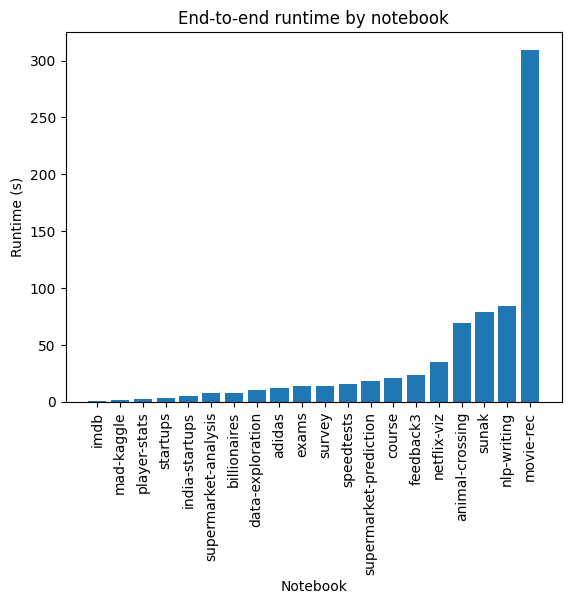

In [68]:
categories = [names_map[n] for n in notebook_names if n in names_map]
total_times = [elapsed_times[n] for n in notebook_names if n in names_map]
assert len(categories) == len(total_times)
plot(categories, total_times, "End-to-end runtime by notebook", 'Notebook', 'Runtime (s)')

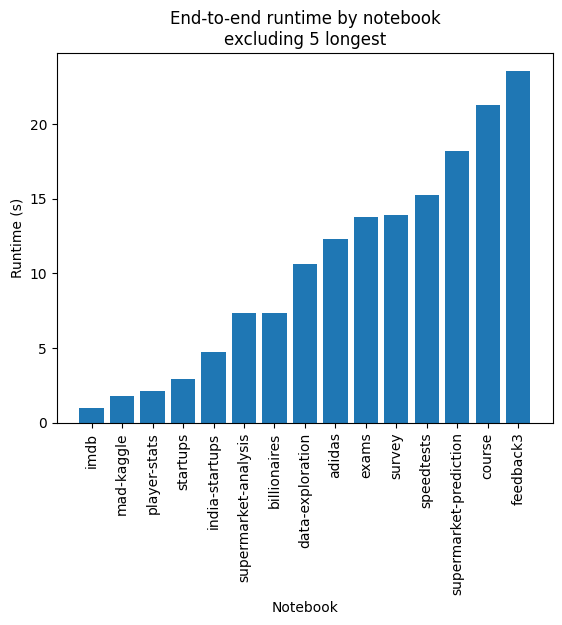

In [70]:
categories = [names_map[n] for n in notebook_names if n in names_map][:-5]
total_times = [elapsed_times[n] for n in notebook_names if n in names_map][:-5]
plot(categories, total_times, "End-to-end runtime by notebook\nexcluding 5 longest", 'Notebook', 'Runtime (s)')

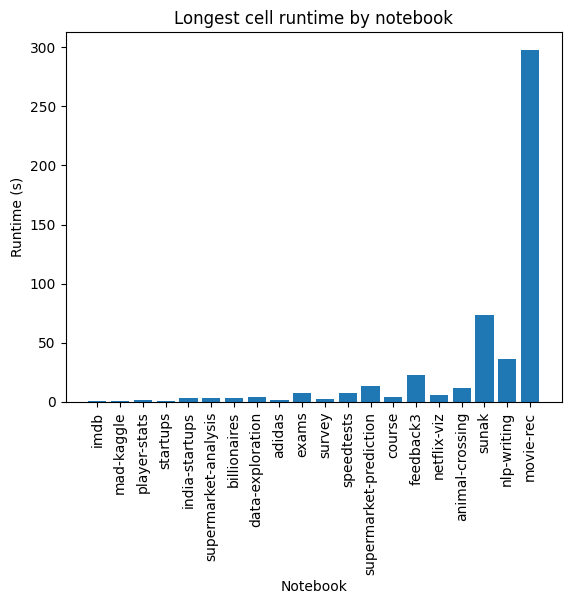

In [71]:
categories = [names_map[n] for n in notebook_names if n in names_map]
max_cell_times = [max([x[0] for x in outer_cell_times[n]]) / 10 ** 3 for n in notebook_names if n in names_map]
plot(categories, max_cell_times, "Longest cell runtime by notebook", 'Notebook', 'Runtime (s)')

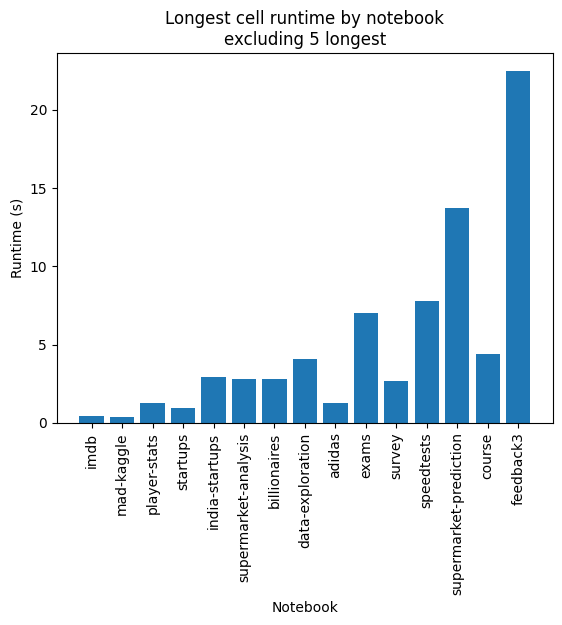

In [72]:
categories = [names_map[n] for n in notebook_names if n in names_map][:-5]
max_cell_times = [max([x[0] for x in outer_cell_times[n]]) / 10 ** 3 for n in notebook_names if n in names_map][:-5]
plot(categories, max_cell_times, "Longest cell runtime by notebook\nexcluding 5 longest", 'Notebook', 'Runtime (s)')

[1000.0, 1020.0, 1020.0, 1030.0, 1030.0, 1030.0, 1040.0, 1050.0, 1060.0, 1070.0, 1110.0, 1120.0, 1130.0, 1140.0, 1150.0, 1210.0, 1210.0, 1210.0, 1240.0, 1270.0, 1280.0, 1290.0, 1290.0, 1310.0, 1320.0, 1710.0, 1810.0, 1820.0, 1860.0, 1880.0, 1890.0, 1930.0, 2040.0, 2100.0, 2280.0, 2290.0, 2300.0, 2380.0, 2520.0, 2670.0, 2690.0, 2780.0, 2780.0, 2780.0, 2900.0, 3160.0, 3170.0, 3460.0, 3490.0, 3500.0, 3620.0, 3740.0, 4000.0, 4070.0000000000005, 4420.0, 4590.0, 4720.0, 4730.0, 5340.0, 5510.0, 5610.0, 5660.0, 5940.0, 6300.0, 7000.0, 7420.0, 7450.0, 7480.0, 7780.0, 8029.999999999999, 9740.0, 9890.0, 9960.0]


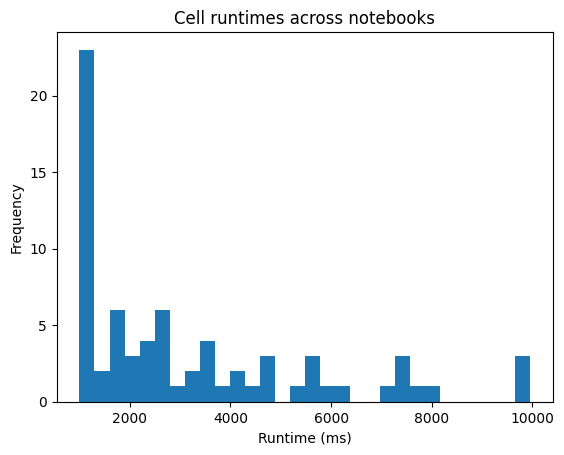

In [73]:
cell_times_flat = [c[0] for c in itertools.chain.from_iterable(outer_cell_times.values()) if c[0] >= 1000 and c[0] <= 10000]
print(sorted(cell_times_flat))
plt.figure()
plt.hist(cell_times_flat, bins=30)
plt.title("Cell runtimes across notebooks")
plt.xlabel("Runtime (ms)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
list(cell_times_flat)

[1020.0,
 1430.0,
 1170.0,
 2100.0,
 1970.0,
 1840.0,
 1120.0,
 5960.0,
 3500.0,
 1130.0,
 2770.0,
 3570.0,
 1150.0,
 2380.0,
 3190.0,
 4740.0,
 2310.0,
 2310.0,
 4030.0000000000005,
 1950.0,
 3120.0,
 1720.0,
 1680.0,
 1190.0,
 2410.0,
 1880.0,
 1080.0,
 6640.0,
 5430.0,
 2480.0,
 8350.0,
 1460.0,
 4340.0,
 2630.0,
 2620.0,
 1440.0,
 2600.0,
 4270.0,
 5210.0,
 4190.0,
 4190.0,
 2009.9999999999998,
 9890.0,
 1310.0,
 9740.0]